###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**    1013239  &  1012861


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [49]:
# PREPROCESSING
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

import numpy as np
import pandas as pd
from collections import defaultdict
import re
from math import sqrt
from math import exp
from math import pow
from math import pi
from math import log 
import matplotlib.pyplot as plt
%matplotlib inline

# open & store data from training file
def open_train_file(train_attr_vals, train_classes,filename):
    f = open(filename,'r')
    
    for line in f.readlines()[0:]:
        cleaned_line = line.strip().split(",")
        attributes = cleaned_line[1:]
        class_name = cleaned_line[0]
        
        str_to_float(attributes)
        
        if (mean(attributes) == 9999):
            continue
        else:
            train_attr_vals.append(attributes)
            train_classes.append(class_name)
        
    f.close
    return 

#impute missing values from 9999 to 0 
def remove_missing_values(train_attr_vals):
    for instance in train_attr_vals:
        for i in range(len(instance)):
            if(instance[i]==9999):
                instance[i]=0          
    return

#convert elements in array from string to float                
def str_to_float(attributes):
    for i in range(len(attributes)):
        attributes[i]=float(attributes[i])
    return 

#put training instances into dictionary based on class
def put_into_dict(train_attr_vals,train_classes,class_dict,class_count_dict):
    instance_num = len(train_attr_vals)
    
    for i in range(instance_num):
        attributes = train_attr_vals[i]
        class_name = train_classes[i]
        if class_dict.get(class_name) is None:
            class_dict[class_name]=[]
        # appending each
        class_dict[class_name].append(attributes)
        class_count_dict[class_name] += 1
    return class_dict, class_count_dict

# preprocess the training set : impute missing values and store into wanted structure
def preprocess(train_attr_vals, train_classes, class_dict, class_count_dict):
    
    train_filename = "COMP30027_2021_assignment1_data/train.csv"
    # open training file and store into arrays
    open_train_file(train_attr_vals, train_classes,train_filename)
    
    # impute missing values
    remove_missing_values(train_attr_vals)
    
    # put instances into dictionary based on classes
    put_into_dict(train_attr_vals,train_classes,class_dict,class_count_dict)
    
    return 


In [50]:
# TRAIN
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

#calculate mean from array
def mean(array):
    return (sum(array)/len(array))

#calculate standard deviation from array and calculated mean
def standard_deviation(array,mean_val):
    total = 0
    for one in array:
        total+=(pow((one-mean_val),2))
    result = sqrt(total/(len(array)-1))
    return result

#train using the training data
def train(class_dict, class_count_dict,training_details,attr_length,total_inst):
    
    # training_details dictionary format {key : [[means], [standard deviation], class_prob]}
    for key in class_dict.keys():
        
        if training_details.get(key) is None:
            training_details[key]=[]
            
        #array to store each attributes' mean value
        mean_array=[]
        
        #array to store each standard deviations' value
        std_dev_array=[]
        
        for i in range(attr_length):
            attr_array = [instance[i] for instance in class_dict[key]]
            
            #find mean and standard deviation of current attribute value
            mean_val = mean(attr_array)
            std_dev_val = standard_deviation(attr_array,mean_val) 
            
            mean_array.append(mean_val)
            std_dev_array.append(std_dev_val)
            
        #append mean, standard deviation & class probability to training details dictionary
        training_details[key].append(mean_array)
        training_details[key].append(std_dev_array)
        class_prob = class_count_dict[key]/total_inst
        training_details[key].append(class_prob)
        
    return


In [51]:
# PREDICT
# This function should predict classes for new items in a test dataset (for the purposes of this assignment, you
# can re-use the training data as a test set)

#calculate gaussian distribution
def gaussian_distribution(val,mean,std_dev):
    exponential = exp(-(1/2)* (pow(((val-mean)/std_dev),2)))
    result = (1/(std_dev * sqrt(2*pi)))* exponential
    return result

#to handle log of 0 
def take_log(val):
    if(val==0):
        return 0
    else:
        return log(val)

#calculate the probability of the test instance being classified as each classes
def probability(instance,training_details,attr_num,class_num):
    probs = defaultdict()
    
    #find the likelihood/probability of the instance in each class
    for key in training_details.keys():
        total_prob=0
        sum_gaussian_prob=0
        
        # likelihood of the instance's attribute based on the class
        for i in range(attr_num):
            attr_mean = training_details[key][0][i]
            attr_std_dev = training_details[key][1][i]
            
            gauss_prob = gaussian_distribution(instance[i],attr_mean,attr_std_dev)
            #take_log here to handle log(0) for now as log(0) cant be computed
            sum_gaussian_prob+=take_log(gauss_prob)
            
        # probability of the instance being a class :  log(class prob) + sum(log(each attribute))
        total_prob+=sum_gaussian_prob
        class_prob=training_details[key][2]
        # adding log of class prob
        total_prob+=log(class_prob)
        
        # put in dictionary
        probs[key] = total_prob

    return probs

# predict the classes of test intances
def predict(training_details,attr_num,class_num,test_attr_vals,test_actual_class):
    
    test_filename="COMP30027_2021_assignment1_data/test.csv"
    # open testing file & store data
    open_train_file(test_attr_vals,test_actual_class,test_filename)
    remove_missing_values(test_attr_vals)
    
    predicted_classes=[]
    for instance in test_attr_vals:
        # dictionary to store the probability 
        # of each instances being classified as each classes
        probability_dict = probability(instance,training_details,attr_num,class_num)
        #find the class with the highest probability
        max_prob_class = max(probability_dict, key=probability_dict.get)
        predicted_classes.append(max_prob_class)
    
    return predicted_classes


In [40]:
# EVALUATE
# This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(test_actual_class,predicted_classes):    
        
    correct_label = 0
    test_num=len(test_actual_class)
    for i in range(test_num):
        if(test_actual_class[i]==predicted_classes[i]):
            correct_label+=1

    accuracy = (correct_label / test_num) * 100
    
    return accuracy



In [52]:
#RUN HERE 

#store value of attributes of each instance
train_attr_vals = []

#store class of training isntances
train_classes = []

#class_dict : store all instances per class 
class_dict = defaultdict()

#class_count_dict: store number of instances per class
class_count_dict = defaultdict(int)

#store the details of each class after training
training_details = defaultdict()

#number of attributes
attr_num = 0

#number of instances
total_instances = 0

#class_dict : store all instances per class & class_count_dict: store number of instances per class
preprocess(train_attr_vals, train_classes, class_dict, class_count_dict)

attr_num = len(train_attr_vals[0])
total_instances = sum([class_count_dict[key] for key in class_count_dict.keys()])

#train the data
#result is training_details dict format - {class_name : [[means], [standard deviation], class_prob]}
train(class_dict, class_count_dict, training_details, attr_num, total_instances)

#store values of testing instances
test_attr_vals=[]

#store actual class of testing instances
test_actual_class=[]

#predicted classes of the testing instances
predicted_class_gaussian = predict(training_details,attr_num,len(training_details.keys()),test_attr_vals,test_actual_class)

accuracy = evaluate(test_actual_class,predicted_class_gaussian)
print("Accuracy is ", accuracy,"%")


Accuracy is  73.21428571428571 %


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [53]:
#functions Q1 : macro averaging vs micro averaging

#create confusion matrix
def confusion_matrix(predicted_classes, test_actual_class, class_dict):
    
    # confusion matrix dataframe
    matrix = pd.DataFrame()
    classes = np.unique(np.array(predicted_classes))
    classes = np.append(classes,['fn'])
    matrix['actual'] = classes
    
    #initialise all columns and rows
    zeros = pd.Series(np.zeros((len(classes),), dtype=int))
    for i in range(len(classes)):
        matrix[classes[i]] = zeros
        
    matrix = matrix.set_index('actual')
    matrix.index.name = "predicted ↓ actual →"
    
    for j in range(len(predicted_classes)):
        matrix.loc[predicted_classes[j],test_actual_class[j]]+=1
    
    #calculate fn,tp,fp
    FP=[]
    FN=[]
    TP=[]
    for key in classes:
        # get the tp,fn,fp from the confusion matrix
        tp_one = matrix.loc[key,key] 
        fp_one = sum(matrix.loc[key,:]) - tp_one
        fn_one = sum(matrix.loc[:,key]) - tp_one
        FP.append(fp_one)
        FN.append(fn_one)
        TP.append(tp_one)  
    
    #put fn,tp,fp into dataframe
    matrix['fp'] = FP
    matrix['tp'] = TP
    for i in range(len(FN)):
        matrix.loc['fn',classes[i]]= FN[i]
    del matrix['fn']
    return matrix

#run the macro averaging method   
def macro_averaging(predicted_classes, test_actual_class, class_dict):
    matrix = confusion_matrix(predicted_classes, test_actual_class, class_dict)
    precision = 0
    recall = 0
    for i in class_dict.keys():
        # get the tp,fn,fp from the confusion matrix
        tp = matrix['tp'][i]
        fn = matrix[i].loc['fn']
        fp = matrix['fp'][i]
        precision += (tp/(tp+fp)) #calculate sum of total precision of each class
        recall += (tp/(tp+fn)) #calculate sum of total recall of each class
    
    macro_precision = precision/len(class_dict)
    macro_recall = recall/len(class_dict)
    fscore_macro = (2*macro_precision*macro_recall)/(macro_precision+macro_recall)
    return macro_precision, macro_recall, fscore_macro

#run the micro averaging method
def micro_averaging(predicted_classes, test_actual_class, class_dict):
    matrix = confusion_matrix(predicted_classes, test_actual_class, class_dict)
    total_tp = 0 #total true positive
    total_tp_fp = 0 #total true positive plus false positive (denominator for micro precision)
    total_tp_fn = 0 #total true positive plus false negative (denominator for micro recall)
    for i in class_dict.keys():
        # get the tp,fn,fp from the confusion matrix
        tp = matrix['tp'][i]
        fn = matrix[i].loc['fn']
        fp = matrix['fp'][i]
        total_tp += tp
        total_tp_fp += (tp+fp)
        total_tp_fn += (tp+fn)

    micro_precision = total_tp/total_tp_fp
    micro_recall = total_tp/total_tp_fn
    fscore_micro = (2*micro_precision*micro_recall)/(micro_precision+micro_recall)
    return micro_precision, micro_recall, fscore_micro


In [54]:
# RUN HERE FOR Q1 AFTER RUNNING FUNCTIONS ABOVE
macro_precision, macro_recall, fscore_macro = macro_averaging(predicted_classes, test_actual_class, class_dict)
micro_precision, micro_recall, fscore_micro = micro_averaging(predicted_classes, test_actual_class, class_dict)
display(confusion_matrix(predicted_classes, test_actual_class, class_dict))


print("{:<15}{:^15}{:^15}{:^15}".format("", "Precision", "Recall", "F-score"))
print("{:<15}{:^15}{:^15}{:^15}".format("Macro-averaging", round(macro_precision*100, 5) , round(macro_recall*100,5), round(fscore_macro*100,5)))
print("{:<15}{:^15}{:^15}{:^15}".format("Micro-averaging", round(micro_precision*100, 5) , round(micro_recall*100,5), round(fscore_micro*100,5)))

,bridge,childs,downwarddog,mountain,plank,seatedforwardbend,tree,trianglepose,warrior1,warrior2,fp,tp
predicted ↓ actual →,,,,,,,,,,,,
bridge,6,0,0,0,1,0,0,0,0,0,1,6
childs,3,11,3,0,0,5,0,0,0,0,11,11
downwarddog,3,0,12,0,0,1,1,0,0,0,5,12
mountain,0,0,0,26,0,0,0,0,0,0,0,26
plank,0,0,0,0,5,0,0,0,0,0,0,5
seatedforwardbend,2,1,0,0,1,3,0,0,0,0,4,3
tree,0,0,0,4,0,0,3,0,0,0,4,3
trianglepose,0,0,0,0,2,0,0,4,0,0,2,4
warrior1,0,0,0,0,0,0,2,0,5,1,3,5


                  Precision       Recall         F-score    
Macro-averaging   72.11835       72.75794       72.43673    
Micro-averaging   73.21429       73.21429       73.21429    


### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [55]:
# additional functions for Q3

# train using kde
def KDE(kernel_bandwidth, test_instance, class_dict):
    attribute_num = len(test_instance)
    
    total_instance_n = sum([len(class_dict[key]) for key in class_dict.keys()])
    
    # dictionary to store probabilities of the test instance classified as each class
    # {class name: probability}
    probs = defaultdict()
    
    for key in class_dict.keys():
        train_instances = class_dict[key]
        train_instance_num = len(class_dict[key])
        test_instance_prob = 0
        
        # for each attribute value of the test instance 
        for i in range(attribute_num):
            
            # array containing all values of the attributes from training data per class
            column_i = [one_train[i] for one_train in train_instances]
            
            # total of probability of each attribute's val
            col_i_prob = 0
       
            for j in range(len(column_i)):
                # gaussian_distribution(val,mean,std_dev)
                # 𝜙(𝑥−𝑥i)
                gaussian_kde = (gaussian_distribution(test_instance[i],column_i[j],kernel_bandwidth))
                # sum(𝜙(𝑥−𝑥i))
                col_i_prob += (gaussian_kde)
            # sum(𝜙(𝑥−𝑥i)) / num of train instance
            col_i_prob /= train_instance_num
            
            test_instance_prob+=take_log(col_i_prob)
            
        # log(class probability) + log(sum(𝜙(𝑥−𝑥i)) / num of train instance)
        test_instance_prob+=take_log(len(class_dict[key])/total_instance_n)
        
        #store the probability being classified to current class into dictionary
        probs[key] = test_instance_prob

    return probs

# predict using kde
def predict_kde(bandwidth,test_attr_vals_q3,class_dict):
    
    predicted_classes=[]
    for instance in test_attr_vals_q3:
        # dictionary to store the probability 
        # of the instance being classified as each classes
        probability_dict = KDE(bandwidth,instance,class_dict)
                 
        #find the class with the highest probability
        max_prob_class = max(probability_dict, key=probability_dict.get)

        predicted_classes.append(max_prob_class)
    
    return predicted_classes

# similarity when using kde vs gaussian naive bayes
def kde_vs_gaussian(predicted_kde, predicted_gaussian):
    same = 0
    for i in range(len(predicted_kde)):
        if (predicted_kde[i] == predicted_gaussian[i]):
            same += 1
    return (same/len(predicted_kde))*100


In [61]:
# RUN HERE FOR Q3 AFTER RUNNING FUNCTIONS ABOVE

test_attr_vals_q3=[]
test_actual_class_q3=[]

# open testing file & store data
test_filename = "COMP30027_2021_assignment1_data/test.csv"
open_train_file(test_attr_vals_q3,test_actual_class_q3,test_filename)
# impute missing values

remove_missing_values(test_attr_vals_q3)

# find predicted classes of each test instance
predicted_class_kde = predict_kde(10,test_attr_vals_q3,class_dict)

# find accuracy when using kde naive bayes
accuracy_kde_q3 = evaluate(test_actual_class_q3, predicted_class_kde)

#find similarity between kde and gaussian naive bayes in predicting classes
difference_kde_gaussian = kde_vs_gaussian(predicted_class_kde, predicted_class_gaussian)

display(confusion_matrix(predicted, test_actual_class_q3, class_dict))

print("Similarity between KDE and Gaussian is: ", difference_kde_gaussian)

print("KDE Accuracy is :",accuracy_kde_q3)


,bridge,childs,downwarddog,mountain,plank,seatedforwardbend,tree,trianglepose,warrior1,warrior2,fp,tp
predicted ↓ actual →,,,,,,,,,,,,
bridge,8,0,1,0,1,0,1,0,0,0,3,8
childs,1,7,0,0,0,3,0,0,0,0,4,7
downwarddog,4,1,14,0,0,0,0,0,0,0,5,14
mountain,0,0,0,27,0,0,0,0,0,0,0,27
plank,1,0,0,0,7,1,0,0,0,0,2,7
seatedforwardbend,0,4,0,0,0,5,0,0,0,0,4,5
tree,0,0,0,3,0,0,4,0,1,1,5,4
trianglepose,0,0,0,0,0,0,0,4,0,0,0,4
warrior1,0,0,0,0,1,0,1,0,4,0,2,4


Similarity between KDE and Gaussian is:  76.78571428571429
KDE Accuracy is : 75.0


### Q4

Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

In [59]:
# additional functions for 4
from sklearn.model_selection import KFold 


#preprocess training dataset for q4
def preprocess_q4(train_attr_vals_q4, train_classes_q4):
    
    train_filename = "COMP30027_2021_assignment1_data/train.csv"
    # open training file and store into arrays
    open_train_file(train_attr_vals_q4, train_classes_q4,train_filename)
    
    # impute missing values
    remove_missing_values(train_attr_vals_q4)
    return 

#cross validation to choose bandwidth
def cross_val_bandwidth(class_dict_q4,class_count_dict_q4,train_attr_vals_q4,train_classes_q4):

    bandwidth_min=5
    bandwidth_max=26

    kf = KFold(n_splits=7, random_state=1,shuffle=True)
    
    # store the bandwidth which results in the highest probability for each partition
    kf_bandwidth_max=[]

    for train_index , test_index in kf.split(train_attr_vals_q4):
        print("cross validation bandwidth running...")
        k_train_ins = [train_attr_vals_q4[i] for i in train_index]
        k_train_class = [train_classes_q4[i] for i in train_index] 
        k_test_ins = [train_attr_vals_q4[i] for i in test_index]
        k_test_class = [train_classes_q4[i] for i in test_index]

        put_into_dict(k_train_ins,k_train_class,class_dict_q4,class_count_dict_q4)

        # dictionary to store accuracy of current partition with different bandwidth
        # {bandwidth : accuracy}
        diff_bandwidth_accuracy = defaultdict()
        
        # try few different bandwidths for each partition
        for i in range(bandwidth_min,bandwidth_max,5):
            predicted = predict_kde(i,k_test_ins,class_dict_q4)
            accuracy_kde = evaluate(k_test_class, predicted)
            diff_bandwidth_accuracy[i] = accuracy_kde
            
        # find bandwidth with the highest probability
        max_prob_bandwidth = max(diff_bandwidth_accuracy, key=diff_bandwidth_accuracy.get)
        
        # append the best bandwidth to dictionary 
        # which stores best bandwidth for all partitions
        kf_bandwidth_max.append(max_prob_bandwidth)
    
    # average of the best bandwidths found in each partition
    avg = sum(kf_bandwidth_max)/len(kf_bandwidth_max)
    
    print("cross validation bandwidth completed.")
    
    return avg

# displays the kde vs attribute to show the effect 
# when bandwidth = 5 vs bandwidth = 10
# here only displays for attribute x1 of class = bridge
def display_kde(best_bandwidth, arbitrary_bandwidth):

    ax = plt.gca()
    x1=[instance[0] for instance in class_dict_q4['bridge']]
    kde_best_bandwidth=[]
    for i in range(len(x1)):           
        x1_prob = 0
        for j in range(len(x1)):
            gaussian_kde = (gaussian_distribution(x1[i],x1[j],best_bandwidth))
            x1_prob+=gaussian_kde
        kde_best_bandwidth.append(x1_prob/len(x1))
        
    dict_best = {'x1':x1,('kde_'+str(best_bandwidth)):kde_best_bandwidth}
    df_best= pd.DataFrame.from_dict(dict_best)
    df_best.sort_values(by=['x1'],inplace=True)
    df_best.plot(kind='line',x='x1',y=('kde_'+str(best_bandwidth)),color='red',ax=ax)

    
    kde_arbitrary_bandwidth=[]
    for i in range(len(x1)):           
        x1_prob = 0
        for j in range(len(x1)):
            gaussian_kde = (gaussian_distribution(x1[i],x1[j],arbitrary_bandwidth))
            x1_prob+=gaussian_kde
        kde_arbitrary_bandwidth.append(x1_prob/len(x1))
        
    dict_arb = {'x1':x1,('kde_'+str(arbitrary_bandwidth)):kde_arbitrary_bandwidth}
    df_arb= pd.DataFrame.from_dict(dict_arb)
    df_arb.sort_values(by=['x1'],inplace=True)
    df_arb.plot(kind='line',x='x1',y=('kde_'+str(arbitrary_bandwidth)),color='blue',ax=ax)
    
    ax.set_ylabel('kde')
    ax.set_title('kde vs x1 - class = bridge')
    plt.show()
    
    return

cross validation bandwidth running...
cross validation bandwidth running...
cross validation bandwidth running...
cross validation bandwidth running...
cross validation bandwidth running...
cross validation bandwidth running...
cross validation bandwidth running...
cross validation bandwidth completed.
predicting for best bandwidth completed.
best bandwidth is 5.0


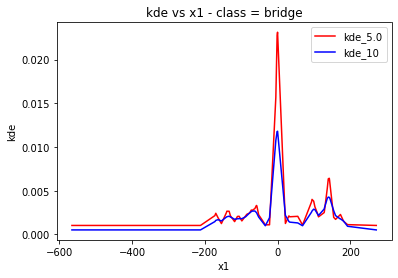

Accuracy using the best bandwidth from above:  77.67857142857143
Accuracy using bandwidth 10 from q3:  75.0


In [62]:
# RUN HERE FOR Q4 AFTER RUNNING THE FUNCTIONS ABOVE

# put training instances based on class
class_dict_q4 = defaultdict() 
class_count_dict_q4 = defaultdict(int)

# store training instances
train_attr_vals_q4 = []
train_classes_q4 = []

# preprocess training instances
preprocess_q4(train_attr_vals_q4, train_classes_q4)

#find the best bandwidth by cross validation
best_bandwidth = cross_val_bandwidth(class_dict_q4,class_count_dict_q4,train_attr_vals_q4,train_classes_q4)

# store test instances 
test_attr_vals_q4 = []
test_actual_class_q4 = []

# open testing file, store & clean data
test_filename = "COMP30027_2021_assignment1_data/test.csv"
open_train_file(test_attr_vals_q4,test_actual_class_q4,test_filename)
remove_missing_values(test_attr_vals_q4)

print("predicting for best bandwidth completed.")
print("best bandwidth is",best_bandwidth)

# find the predicted classes for the test instances when using best bandwidth found
predicted_q4 = predict_kde(best_bandwidth,test_attr_vals_q4,class_dict)

# find accuracy comparing to actual classes
accuracy_kde_q4 = evaluate(test_actual_class_q4, predicted_q4)


# displays the kde vs attribute to show the effect 
# when using best bandwidth found vs arbitrary bandwidth
display_kde(best_bandwidth,10)

print("Accuracy using the best bandwidth from above: ",accuracy_kde_q4)
print("Accuracy using bandwidth 10 from q3: ",accuracy_kde_q3)



##### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

In [66]:
# functions for Q5

# find the mean values of each attribute per class
def mean_of_class(class_dict, mean_dict):
    mean_dict_val = 0
    mean_class_attribute = []
    for keys in class_dict.keys():
        mean_dict[keys] = []
        new_class_count_dict[keys] = 0
        for i in range(len(class_dict[keys][0])):
            for j in range(len(class_dict[keys])):
                mean_class_attribute.append(class_dict[keys][j][i])
                
            mean_dict_val = mean(mean_class_attribute)
            mean_dict[keys].append(mean_dict_val)
            mean_dict_val = 0
            mean_class_attribute = []    
            
    return mean_dict

# impute missing values with mean
def impute_mean(mean_dict, new_class_dict):
    for keys in new_class_dict.keys():
        for i in range(len(new_class_dict[keys])): #num instances
            for j in range(len(new_class_dict[keys][0])):
                if (new_class_dict[keys][i][j] == 0):
                    new_class_dict[keys][i][j] = mean_dict[keys][j]
    return 



In [67]:
# RUN HERE FOR Q5 AFTER RUNNING FUNCTIONS ABOVE

mean_dict = defaultdict()
new_class_dict = class_dict
mean_dict = mean_of_class(class_dict, mean_dict)

# impute missing values with the mean of respective attribute of the class
impute_mean(mean_dict, new_class_dict)

training_details_q5 = defaultdict()

# train the new dataset
train(new_class_dict, class_count_dict, training_details_q5, attr_num, total_instances)

# store values of testing instances
test_attr_vals_q5=[]

# store actual class of testing instances
test_actual_class_q5=[]
predicted_classes_q5 =[]

# predicted classes of the testing instances
predicted_classes_q5 = predict(training_details_q5,attr_num,len(training_details_q5.keys()),test_attr_vals_q5,test_actual_class_q5)

predicted_q5 = predict_kde(5,test_attr_vals_q5,class_dict)
accuracy_kde_q5 = evaluate(test_actual_class_q5, predicted_q5)

#evaluate accuracy
new_accuracy = evaluate(test_actual_class_q5,predicted_classes_q5)

print("{:<15}{:^15}{:^15}".format("", "0-imputation", "Mean imputation"))
print("{:<15}{:^15}{:^15}".format("Gaussian", round(accuracy,2) , round(new_accuracy,2)))
print("{:<15}{:^15}{:^15}".format("KDE", round(accuracy_kde,2) , round(accuracy_kde_q5,2)))


NameError: name 'new_class_count_dict' is not defined

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.